## This notebook uses a similar (though different dataset) than the one we proposed to use (HAM10000). The benefit of this data set is that the classes are balanced.
You can find the link to the dataset here: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data 

In [1]:
import sys; sys.version

'3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:29:04) [MSC v.1929 64 bit (AMD64)]'

## LOADING DATA FROM KAGGLE
Note: This data contains balanced classes for benign and malignant.

#### Download the dataset directly from Kaggle:

In [4]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images


  0%|          | 0.00/98.7M [00:00<?, ?B/s]
  2%|▏         | 2.00M/98.7M [00:00<00:06, 16.5MB/s]
  7%|▋         | 7.00M/98.7M [00:00<00:03, 27.8MB/s]
 10%|█         | 10.0M/98.7M [00:00<00:03, 28.6MB/s]
 17%|█▋        | 17.0M/98.7M [00:00<00:03, 28.4MB/s]
 23%|██▎       | 23.0M/98.7M [00:00<00:02, 35.5MB/s]
 27%|██▋       | 27.0M/98.7M [00:00<00:02, 30.4MB/s]
 33%|███▎      | 33.0M/98.7M [00:01<00:02, 30.3MB/s]
 41%|████      | 40.0M/98.7M [00:01<00:01, 37.5MB/s]
 45%|████▍     | 44.0M/98.7M [00:01<00:01, 34.6MB/s]
 49%|████▊     | 48.0M/98.7M [00:01<00:01, 36.1MB/s]
 53%|█████▎    | 52.0M/98.7M [00:01<00:01, 34.5MB/s]
 60%|█████▉    | 59.0M/98.7M [00:01<00:00, 42.7MB/s]
 66%|██████▌   | 65.0M/98.7M [00:01<00:00, 46.2MB/s]
 71%|███████   | 70.0M/98.7M [00:02<00:00, 44.6MB/s]
 79%|███████▉  | 78.0M/98.7M [00:02<00:00, 53.5MB/s]
 85%|████████▌ | 84.0M/98.7M [00:02<00:00, 54.7MB/s]
 91%|█████████ | 90.0M/98.7M [00:02<00:00, 48.5MB/s]
 99%|█████████▉| 98.0M/98.7M [00:02<00:00, 57.0MB/s]
1

In [8]:
import zipfile
zip_ref = zipfile.ZipFile('melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('kaggle')
zip_ref.close()

In [9]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [11]:
train_path = r'kaggle\melanoma_cancer_dataset\train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [12]:
test_path = r'kaggle\melanoma_cancer_dataset\test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


In [41]:
# For training dataset
train_labels = []
for _, labels in ds:
    train_labels.extend(labels.numpy())

# Convert to numpy array for easier counting
train_labels = np.array(train_labels)

# Get unique labels and their counts
unique_labels, train_counts = np.unique(train_labels, return_counts=True)

print("\nTraining Dataset Class Distribution:")
for label, count in zip(unique_labels, train_counts):
    percentage = (count / len(train_labels)) * 100
    print(f"Class {label}: {count} images ({percentage:.2f}%)")

# For test dataset
test_labels = []
for _, labels in test:
    test_labels.extend(labels.numpy())

# Convert to numpy array for easier counting
test_labels = np.array(test_labels)

# Get unique labels and their counts
unique_labels, test_counts = np.unique(test_labels, return_counts=True)

print("\nTest Dataset Class Distribution:")
for label, count in zip(unique_labels, test_counts):
    percentage = (count / len(test_labels)) * 100
    print(f"Class {label}: {count} images ({percentage:.2f}%)")

# Print total counts
print(f"\nTotal training images: {len(train_labels)}")
print(f"Total test images: {len(test_labels)}")


Training Dataset Class Distribution:
Class 0: 5000 images (52.06%)
Class 1: 4605 images (47.94%)

Test Dataset Class Distribution:
Class 0: 500 images (50.00%)
Class 1: 500 images (50.00%)

Total training images: 9605
Total test images: 1000


## DATASET SPLITTING

In [13]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


## DATASET VISUALIZATION

In [14]:
import matplotlib.pyplot as plt

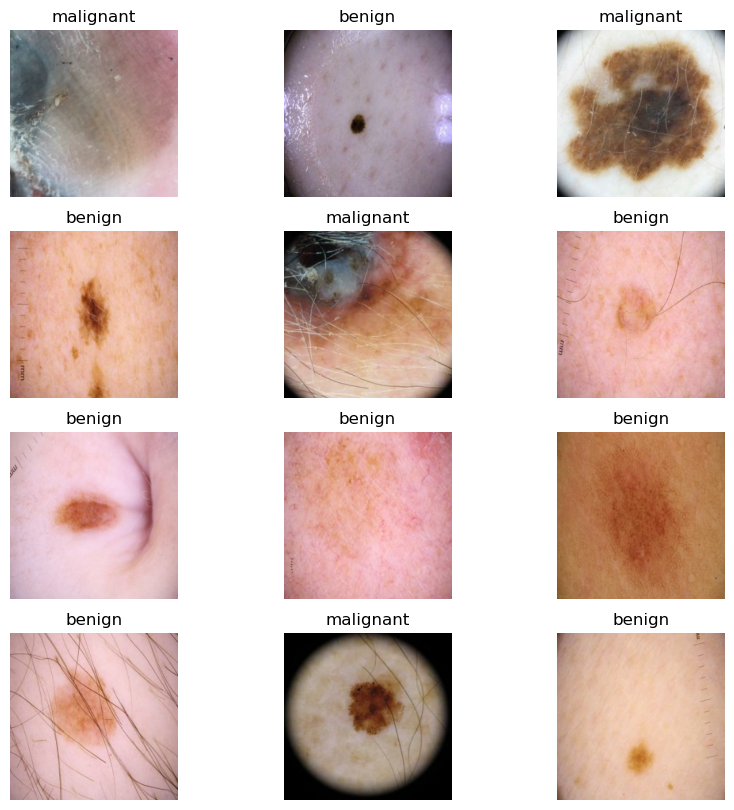

In [15]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

## MODEL BUILDING

In [16]:
from keras.layers import RandomFlip, RandomRotation

In [17]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [18]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [19]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="softmax"),
])

model.build (input_shape=(None, 256, 256, 3))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,522 (216.88 KB)

 Trainable params: 55,522 (216.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)

In [21]:
from keras.callbacks import EarlyStopping

In [22]:
early_stopping = EarlyStopping(
    monitor = 'accuracy',
    patience = 3,
    restore_best_weights = True,
)

MODEL TRAINING

In [23]:
history = model.fit(train, batch_size= 32, epochs=25, verbose=1, validation_data=val, callbacks=[early_stopping])

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.6585 - loss: 0.5816 - val_accuracy: 0.8291 - val_loss: 0.3685
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.8469 - loss: 0.3491 - val_accuracy: 0.8504 - val_loss: 0.3402
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.8566 - loss: 0.3319 - val_accuracy: 0.8686 - val_loss: 0.3218
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - accuracy: 0.8603 - loss: 0.3239 - val_accuracy: 0.8535 - val_loss: 0.3487
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 66s 275ms/step - accuracy: 0.8696 - loss: 0.3161 - val_accuracy: 0.8696 - val_loss: 0.3160
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 225ms/step - accuracy: 0.8759 - loss: 0.3006 - val_accuracy: 0.8686 - val_loss: 0.3130
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - accuracy: 0.8698 - loss: 0.3014 - val_accuracy: 0.8706 - val_loss: 0.2916
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.8767 - loss: 0

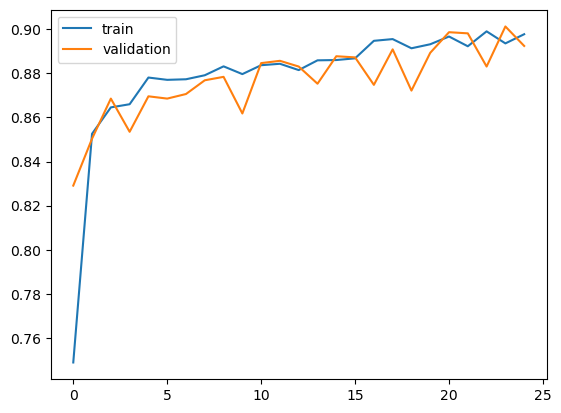

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

## MODEL EVALUATION

In [25]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9049 - loss: 0.2512
0.25468742847442627 0.9020000100135803


Actual Label:  malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label:  malignant


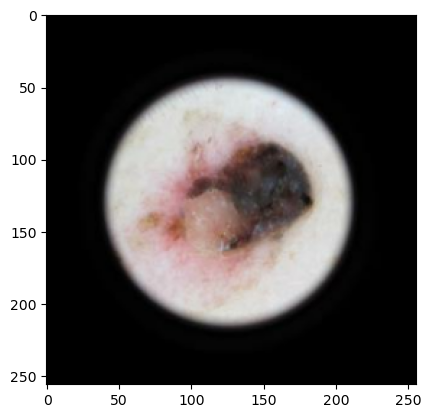

In [35]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [27]:
model.save('model.keras')

## CONFUSION MATRIX & PERFORMANCE EVALUATION

In [28]:
true, predicted = [], []
for images, labels in test:
    for img, label in zip(images, labels):
        true.append(label.numpy())
        pred = model.predict(tf.expand_dims(img, axis=0))
        predicted.append(np.argmax(pred[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

<Axes: >

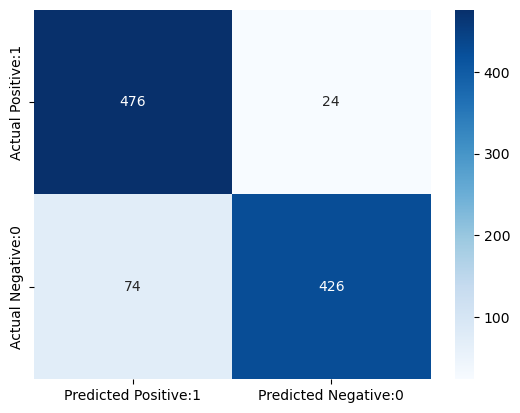

In [32]:
cm = confusion_matrix(true, predicted)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Positive:1', 'Predicted Negative:0'], index=['Actual Positive:1', 'Actual Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt = 'd', cmap='Blues')

## Now, let's try to see how hair removal affects the performance:

In [37]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def preprocess_image(image):
    """Apply hair removal and preprocessing to an image"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    _, hair_mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    hairless_image = cv2.inpaint(image, hair_mask, 6, cv2.INPAINT_TELEA)
    return hairless_image

def process_dataset(source_path, dest_path):
    """Process all images in the source directory and maintain folder structure"""
    # Create destination parent directory if it doesn't exist
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Walk through all subdirectories
    for root, dirs, files in os.walk(source_path):
        # Create corresponding directory structure in destination
        rel_path = os.path.relpath(root, source_path)
        dest_dir = os.path.join(dest_path, rel_path)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        
        # Process each image in current directory
        for file in tqdm(files, desc=f"Processing {rel_path}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Read image
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path)
                
                if image is not None:
                    # Preprocess image
                    processed_image = preprocess_image(image)
                    
                    # Save processed image
                    dest_file = os.path.join(dest_dir, file)
                    cv2.imwrite(dest_file, processed_image)

# Process train and test datasets
train_source = r'kaggle\melanoma_cancer_dataset\train'
train_dest = r'kaggle\melanoma_cancer_dataset\train_preprocessed'
test_source = r'kaggle\melanoma_cancer_dataset\test'
test_dest = r'kaggle\melanoma_cancer_dataset\test_preprocessed'

print("Processing training dataset...")
process_dataset(train_source, train_dest)

print("\nProcessing test dataset...")
process_dataset(test_source, test_dest)

print("\nPreprocessing complete!")

Processing training dataset...


Processing .: 0it [00:00, ?it/s]
Processing malignant: 100%|██████████| 4605/4605 [02:17<00:00, 33.39it/s]



Processing test dataset...


Processing .: 0it [00:00, ?it/s]
Processing malignant: 100%|██████████| 500/500 [00:14<00:00, 34.57it/s]


Preprocessing complete!


Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
240 61


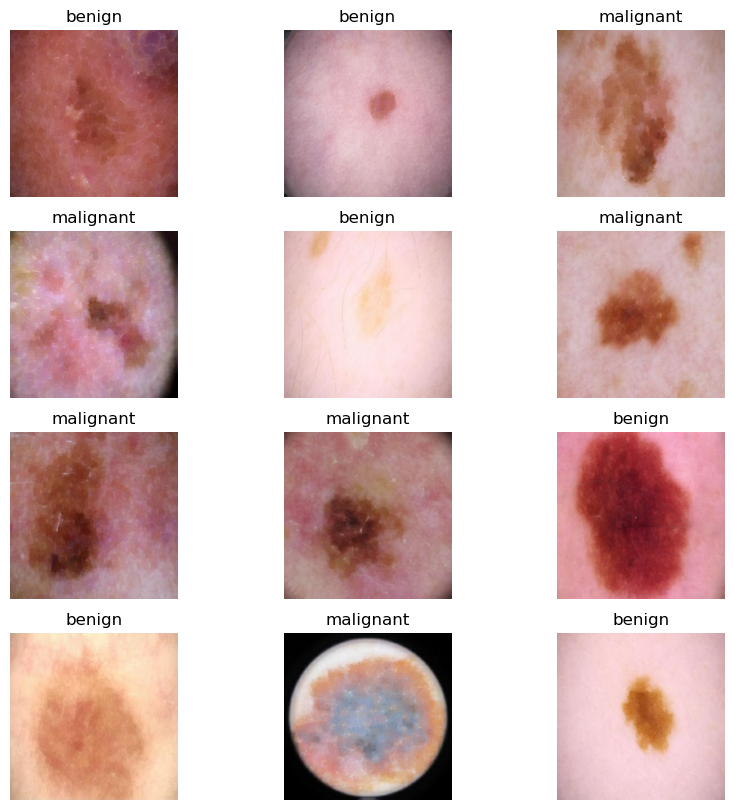

In [39]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

# the labels are in the folder names "benign" and "malignlant" inside the train and test folders. 
train_path = r'kaggle\melanoma_cancer_dataset\train_preprocessed'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

test_path = r'kaggle\melanoma_cancer_dataset\test_preprocessed'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

import matplotlib.pyplot as plt

class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')



Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Train set size: 240
Validation set size: 61

Class distribution in Train set:
benign: 4042 images (52.63%)
malignant: 3638 images (47.37%)

Class distribution in Validation set:
benign: 968 images (50.29%)
malignant: 957 images (49.71%)

Class distribution in Test set:
benign: 500 images (50.00%)
malignant: 500 images (50.00%)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,810 (436.76 KB)

 Trainable params: 111,810 (436.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 190ms/step - accuracy: 0.6872 - loss: 0.5674 - val_accuracy: 0.8540 - val_loss: 0.3458
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 65s 271ms/step - accuracy: 0.8366 - loss: 0.3677 - val_accuracy: 0.8436 - val_loss: 0.3919
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 52s 217ms/step - accuracy: 0.8544 - loss: 0.3405 - val_accuracy: 0.8779 - val_loss: 0.2882
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.8701 - loss: 0.3101 - val_accuracy: 0.8862 - val_loss: 0.2704
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 55s 231ms/step - accuracy: 0.8777 - loss: 0.3091 - val_accuracy: 0.8639 - val_loss: 0.3090
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 210ms/step - accuracy: 0.8733 - loss: 0.3013 - val_accuracy: 0.8909 - val_loss: 0.2656
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 208ms/step - accuracy: 0.8755 - loss: 0.2945 - val_accuracy: 0.8816 - val_loss: 0.2716
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 55s 227ms/step - accuracy: 0.8896 - loss: 0

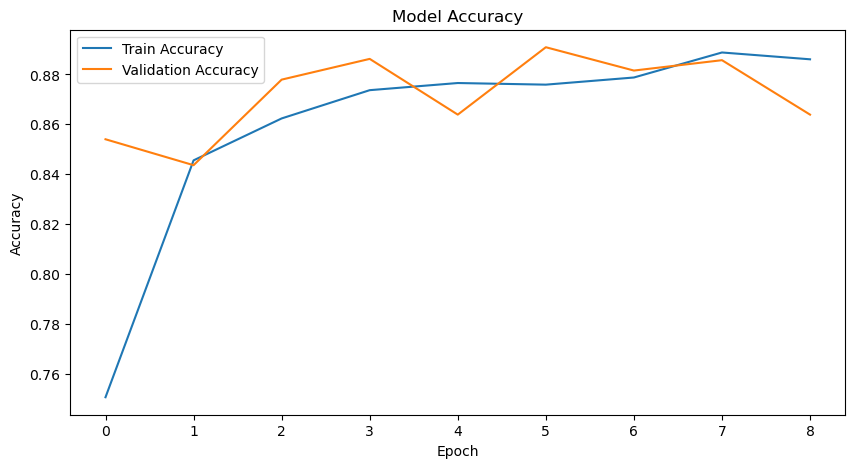

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8813 - loss: 0.2823
Test Loss: 0.2575
Test Accuracy: 0.8960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

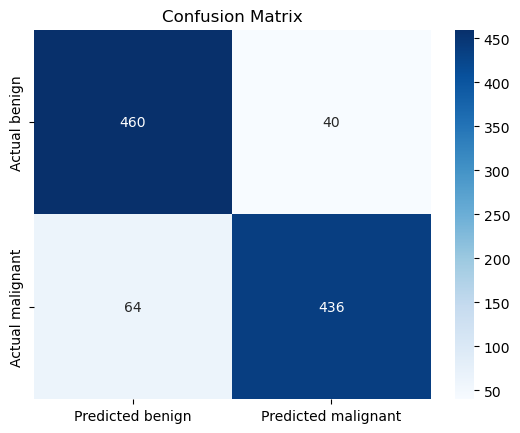

True Positives (TP): 436
False Positives (FP): 40
True Negatives (TN): 460
False Negatives (FN): 64
Sensitivity (Recall): 0.8720
Specificity: 0.9200

Classification Report:
               precision    recall  f1-score   support

      benign       0.88      0.92      0.90       500
   malignant       0.92      0.87      0.89       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



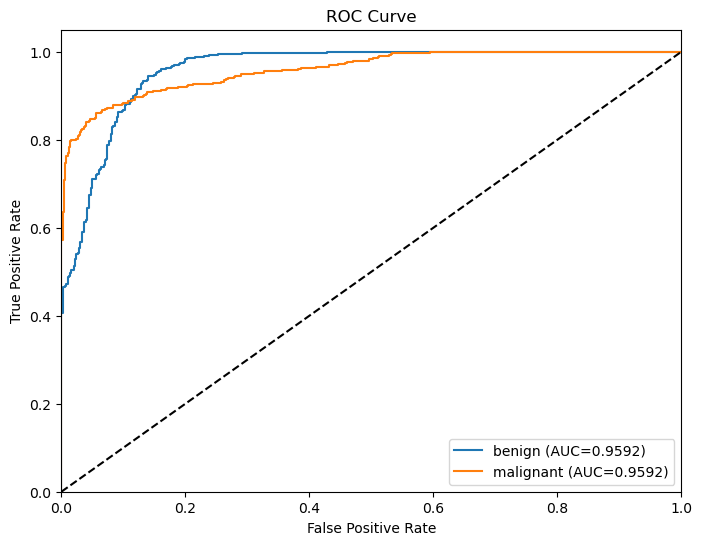

In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

# Load datasets from preprocessed directories
train_path = r'kaggle\melanoma_cancer_dataset\train_preprocessed'
test_path = r'kaggle\melanoma_cancer_dataset\test_preprocessed'

# Load train and test datasets
ds = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

test = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

# Split the dataset into train and validation sets
DATASET_SIZE = len(ds)
TRAIN_RATIO = 0.8

train = ds.take(int(DATASET_SIZE * TRAIN_RATIO))
val = ds.skip(int(DATASET_SIZE * TRAIN_RATIO))

print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(val)}")

# Display class names and dataset distribution for train/validation/test sets
class_names = ds.class_names

def display_class_distribution(dataset, set_name):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass distribution in {set_name} set:")
    for label, count in zip(unique_labels, counts):
        print(f"{class_names[label]}: {count} images ({(count / len(labels)) * 100:.2f}%)")

display_class_distribution(train, "Train")
display_class_distribution(val, "Validation")
display_class_distribution(test, "Test")

# Data augmentation layer
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

# Normalize images to [0, 1]
def Normalizer(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train = train.map(Normalizer)
val = val.map(Normalizer)
test = test.map(Normalizer)

# Model architecture
model = Sequential([
    Input(shape=(256, 256, 3)),
    Augmentation,
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="softmax"),
])

model.build(input_shape=(None, 256, 256, 3))
model.summary()

# Compile the model with additional metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
)

# Train the model
history = model.fit(
    train,
    batch_size=32,
    epochs=25,
    validation_data=val,
    callbacks=[early_stopping]
)

# Plot training history (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_testset, accuracy_testset = model.evaluate(test)
print(f"Test Loss: {loss_testset:.4f}")
print(f"Test Accuracy: {accuracy_testset:.4f}")

# Collect true and predicted labels for evaluation metrics
true_labels = []
predicted_labels = []
predicted_probs = []

for images_batch_testset, labels_batch_testset in test:
    true_labels.extend(labels_batch_testset.numpy())
    
    # Predict probabilities for ROC curve later
    preds_probs_batch_testset = model.predict(images_batch_testset)
    
    # Get predicted class labels (highest probability)
    preds_labels_batch_testset = np.argmax(preds_probs_batch_testset, axis=1)
    
    predicted_labels.extend(preds_labels_batch_testset)
    
    # Store predicted probabilities for each class for AUC-ROC curve plotting later.
    predicted_probs.extend(preds_probs_batch_testset)

# Confusion Matrix and Metrics Calculation (FP/TP/FN/TN)
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index=[f'Actual {name}' for name in class_names],
                     columns=[f'Predicted {name}' for name in class_names])

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate TP/FP/FN/TN from confusion matrix
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Sensitivity (Recall) and Specificity calculation
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Precision and F1-score calculation using classification report from sklearn
report = classification_report(true_labels,
                               predicted_labels,
                               target_names=class_names)
print("\nClassification Report:\n", report)

# Plot ROC-AUC Curve for each class ("Benign", "Malignant")
true_labels_onehot_encoded = tf.keras.utils.to_categorical(true_labels)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

for i in range(len(class_names)):
    
    fpr_dict[i], tpr_dict[i], _ = roc_curve(true_labels_onehot_encoded[:, i], np.array(predicted_probs)[:, i])
    
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# Plot ROC curve for both classes ("Benign", "Malignant")
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    
    plt.plot(fpr_dict[i], tpr_dict[i], label=f'{class_names[i]} (AUC={roc_auc_dict[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line representing random classifier

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

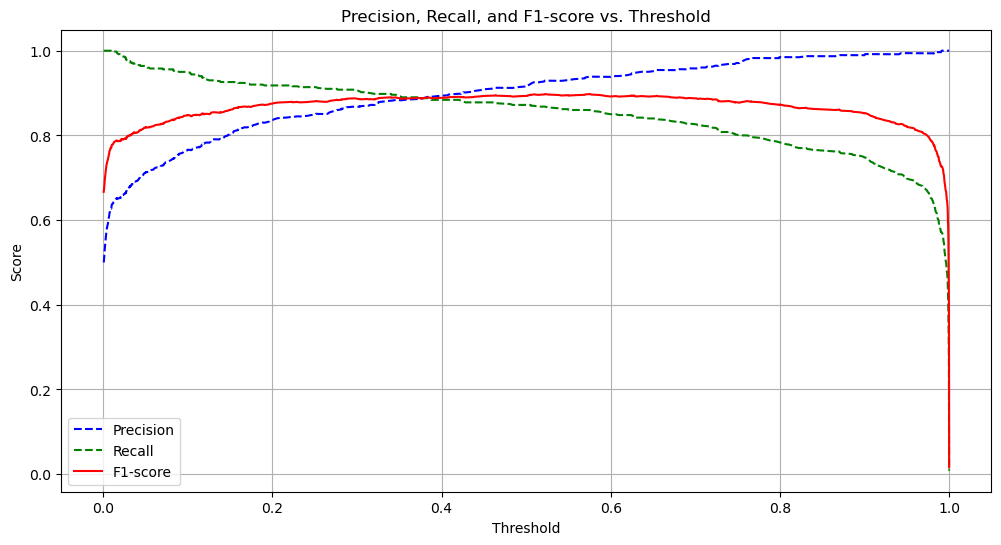

Optimal Threshold (based on F1-score): 0.58


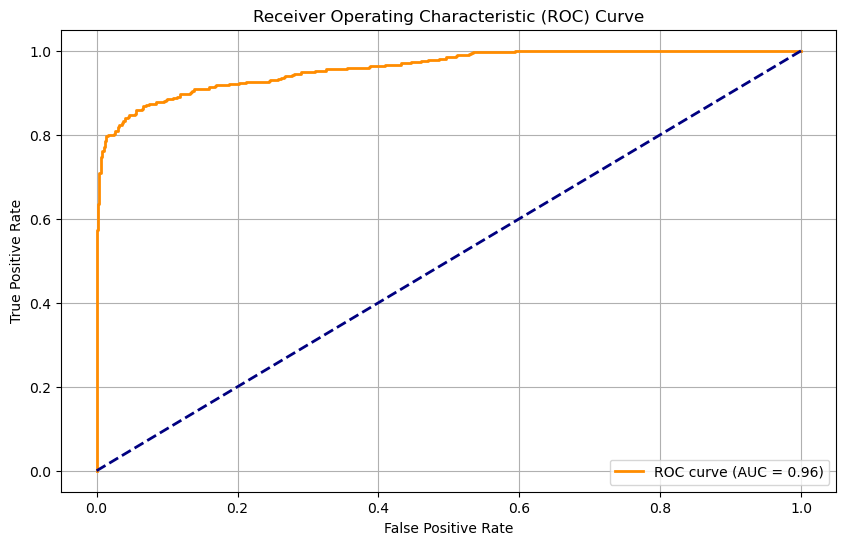

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

      benign       0.87      0.94      0.91       500
   malignant       0.94      0.86      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, classification_report, f1_score
import tensorflow as tf

# Collect true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Collect true labels and predictions from the test set
for images_batch_testset, labels_batch_testset in test:
    true_labels.extend(labels_batch_testset.numpy())
    preds_probs_batch_testset = model.predict(images_batch_testset)
    
    # Store the probability of the "Malignant" class (assumes class 1 is Malignant)
    predicted_probs.extend(preds_probs_batch_testset[:, 1])  # Column 1 for "Malignant" probability

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(true_labels, predicted_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Adding small value to prevent division by zero

# Plot Precision, Recall, and F1-score as a function of the threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds_pr, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds_pr, recall[:-1], 'g--', label='Recall')
plt.plot(thresholds_pr, f1_scores[:-1], 'r-', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Determine the ideal threshold based on F1-score (or choose based on your goal)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]
print(f"Optimal Threshold (based on F1-score): {optimal_threshold:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds_roc = roc_curve(true_labels, predicted_probs)
roc_auc = roc_auc_score(true_labels, predicted_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Evaluate at the chosen threshold
predicted_labels = (predicted_probs > optimal_threshold).astype(int)

# Classification report
print("Classification Report at Optimal Threshold:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


## Finetuning using optimal threshold determined above.

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Train set size: 240
Validation set size: 61

Class distribution in Train set:
benign: 3962 images (51.59%)
malignant: 3718 images (48.41%)

Class distribution in Validation set:
benign: 1033 images (53.66%)
malignant: 892 images (46.34%)

Class distribution in Test set:
benign: 500 images (50.00%)
malignant: 500 images (50.00%)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,745 (436.50 KB)

 Trainable params: 111,745 (436.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - auc: 0.7458 - loss: 0.6054 - precision: 0.7505 - recall: 0.2881 - val_auc: 0.9193 - val_loss: 0.3966 - val_precision: 0.7641 - val_recall: 0.8879
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 60s 250ms/step - auc: 0.9134 - loss: 0.3741 - precision: 0.8428 - recall: 0.7906 - val_auc: 0.9339 - val_loss: 0.3348 - val_precision: 0.8271 - val_recall: 0.8475
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 59s 247ms/step - auc: 0.9255 - loss: 0.3468 - precision: 0.8529 - recall: 0.8096 - val_auc: 0.9396 - val_loss: 0.3143 - val_precision: 0.8515 - val_recall: 0.8477
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - auc: 0.9337 - loss: 0.3283 - precision: 0.8558 - recall: 0.8305 - val_auc: 0.9404 - val_loss: 0.4319 - val_precision: 0.7288 - val_recall: 0.9559
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 56s 233ms/step - auc: 0.9419 - loss: 0.3091 - precision: 0.8686 - recall: 0.8490 - val_auc: 0.9477 - val_loss: 0.3133 - val_precision: 0.8187 - val_

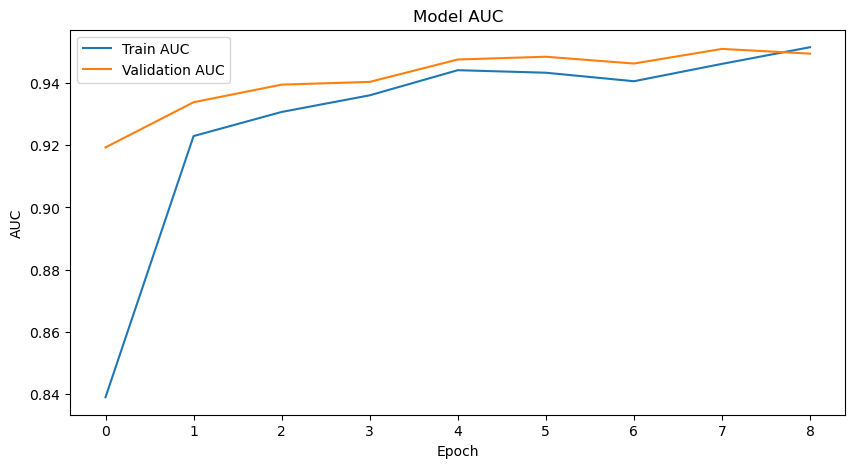

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - auc: 0.9441 - loss: 0.3914 - precision: 0.7580 - recall: 0.9464
Test Loss: 0.3842
Test AUC: 0.9478
Test Precision: 0.7645
Test Recall: 0.9480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━

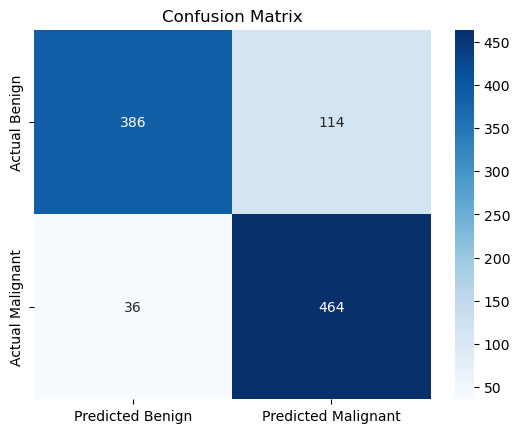

True Positives (TP): 464
False Positives (FP): 114
True Negatives (TN): 386
False Negatives (FN): 36
Sensitivity (Recall): 0.9280
Specificity: 0.7720

Classification Report:
               precision    recall  f1-score   support

      Benign       0.91      0.77      0.84       500
   Malignant       0.80      0.93      0.86       500

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



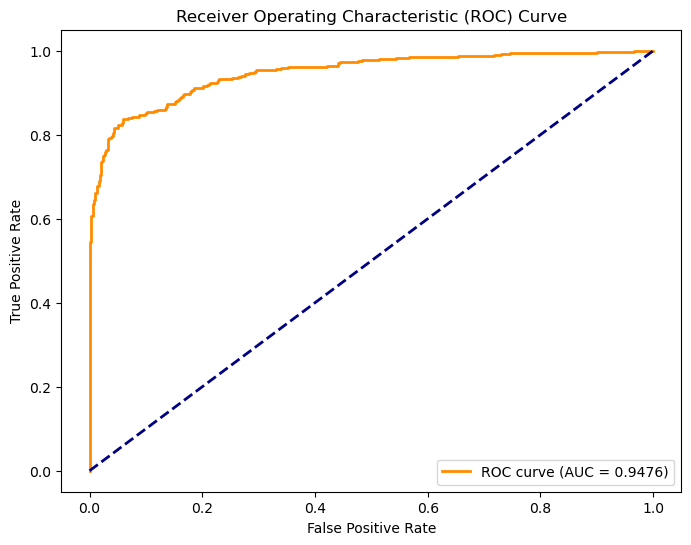

In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

# Load datasets from preprocessed directories
train_path = r'kaggle\melanoma_cancer_dataset\train_preprocessed'
test_path = r'kaggle\melanoma_cancer_dataset\test_preprocessed'

# Load train and test datasets
ds = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

test = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

# Split the dataset into train and validation sets
DATASET_SIZE = len(ds)
TRAIN_RATIO = 0.8

train = ds.take(int(DATASET_SIZE * TRAIN_RATIO))
val = ds.skip(int(DATASET_SIZE * TRAIN_RATIO))

print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(val)}")

# Display class names and dataset distribution for train/validation/test sets
class_names = ds.class_names

def display_class_distribution(dataset, set_name):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass distribution in {set_name} set:")
    for label, count in zip(unique_labels, counts):
        print(f"{class_names[label]}: {count} images ({(count / len(labels)) * 100:.2f}%)")

display_class_distribution(train, "Train")
display_class_distribution(val, "Validation")
display_class_distribution(test, "Test")

# Data augmentation layer
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

# Normalize images to [0, 1]
def Normalizer(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train = train.map(Normalizer)
val = val.map(Normalizer)
test = test.map(Normalizer)

# Model architecture
model = Sequential([
    Input(shape=(256, 256, 3)),
    Augmentation,
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=1, activation="sigmoid"),  # Single output with sigmoid activation for binary classification
])

model.build(input_shape=(None, 256, 256, 3))
model.summary()

# Compile the model with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_recall',  # Focus on maximizing recall
    patience=5,
    restore_best_weights=True,
    mode='max'
)

# Train the model
history = model.fit(
    train,
    epochs=50,  # Increase the epochs if necessary
    validation_data=val,
    callbacks=[early_stopping]
)

# Plot training history (AUC)
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_testset, auc_testset, precision_testset, recall_testset = model.evaluate(test)
print(f"Test Loss: {loss_testset:.4f}")
print(f"Test AUC: {auc_testset:.4f}")
print(f"Test Precision: {precision_testset:.4f}")
print(f"Test Recall: {recall_testset:.4f}")

# Collect true and predicted labels for evaluation metrics
true_labels = []
predicted_labels = []
predicted_probs = []

for images_batch_testset, labels_batch_testset in test:
    true_labels.extend(labels_batch_testset.numpy())
    
    # Predict probabilities for ROC curve later
    preds_probs_batch_testset = model.predict(images_batch_testset)
    
    # Use the probability of the "Malignant" class (single output sigmoid)
    predicted_probs.extend(preds_probs_batch_testset.flatten())
    
    # Apply the optimal threshold of 0.58
    preds_labels_batch_testset = (preds_probs_batch_testset.flatten() > 0.58).astype(int)
    predicted_labels.extend(preds_labels_batch_testset)

# Confusion Matrix and Metrics Calculation (FP/TP/FN/TN)
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index=['Actual Benign', 'Actual Malignant'],
                     columns=['Predicted Benign', 'Predicted Malignant'])

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate TP/FP/FN/TN from confusion matrix
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Sensitivity (Recall) and Specificity calculation
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Precision and F1-score calculation using classification report from sklearn
report = classification_report(true_labels,
                               predicted_labels,
                               target_names=['Benign', 'Malignant'])
print("\nClassification Report:\n", report)

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

# Load datasets from preprocessed directories
train_path = r'kaggle\melanoma_cancer_dataset\train_preprocessed'
test_path = r'kaggle\melanoma_cancer_dataset\test_preprocessed'

# Load train and test datasets
ds = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

test = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

# Split the dataset into train and validation sets
DATASET_SIZE = len(ds)
TRAIN_RATIO = 0.8

train = ds.take(int(DATASET_SIZE * TRAIN_RATIO))
val = ds.skip(int(DATASET_SIZE * TRAIN_RATIO))

print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(val)}")

# Display class names and dataset distribution for train/validation/test sets
class_names = ds.class_names

def display_class_distribution(dataset, set_name):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass distribution in {set_name} set:")
    for label, count in zip(unique_labels, counts):
        print(f"{class_names[label]}: {count} images ({(count / len(labels)) * 100:.2f}%)")

display_class_distribution(train, "Train")
display_class_distribution(val, "Validation")
display_class_distribution(test, "Test")

# Data augmentation layer
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

# Normalize images to [0, 1]
def Normalizer(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train = train.map(Normalizer)
val = val.map(Normalizer)
test = test.map(Normalizer)

# Model architecture
model = Sequential([
    Input(shape=(256, 256, 3)),
    Augmentation,
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=1, activation="sigmoid"),  # Single output with sigmoid activation for binary classification
])

model.build(input_shape=(None, 256, 256, 3))
model.summary()

# Compile the model with additional metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_recall',  # Focus on maximizing recall
    patience=5,
    restore_best_weights=True,
    mode='max'
)

# Train the model
history = model.fit(
    train,
    epochs=50,  # Increase the epochs if necessary
    validation_data=val,
    callbacks=[early_stopping]
)

# Plot training history (AUC)
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_testset, auc_testset, precision_testset, recall_testset = model.evaluate(test)
print(f"Test Loss: {loss_testset:.4f}")
print(f"Test AUC: {auc_testset:.4f}")
print(f"Test Precision: {precision_testset:.4f}")
print(f"Test Recall: {recall_testset:.4f}")

# Collect true and predicted labels for evaluation metrics
true_labels = []
predicted_labels = []
predicted_probs = []

for images_batch_testset, labels_batch_testset in test:
    true_labels.extend(labels_batch_testset.numpy())
    
    # Predict probabilities for ROC curve later
    preds_probs_batch_testset = model.predict(images_batch_testset)
    
    # Use the probability of the "Malignant" class (single output sigmoid)
    predicted_probs.extend(preds_probs_batch_testset.flatten())
    
    # Apply the optimal threshold of 0.58
    preds_labels_batch_testset = (preds_probs_batch_testset.flatten() > 0.58).astype(int)
    predicted_labels.extend(preds_labels_batch_testset)

# Confusion Matrix and Metrics Calculation (FP/TP/FN/TN)
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index=['Actual Benign', 'Actual Malignant'],
                     columns=['Predicted Benign', 'Predicted Malignant'])

sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate TP/FP/FN/TN from confusion matrix
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Sensitivity (Recall) and Specificity calculation
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Precision and F1-score calculation using classification report from sklearn
report = classification_report(true_labels,
                               predicted_labels,
                               target_names=['Benign', 'Malignant'])
print("\nClassification Report:\n", report)

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()